In [1]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, ccf
import statsmodels.api as sm

# visualizations
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'
print(dataTA.shape) 
dataTA.head()

(120, 4)


,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-01-01,436.0,23.06,77.55,2.80
2012-02-01,493.0,23.50,78.69,6.33
2012-03-01,519.0,23.50,74.48,5.33
2012-04-01,482.0,24.00,81.00,3.00
2012-05-01,573.0,23.60,77.23,6.75


KUMPULAN FUNGSI

In [3]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [4]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res['inv_'+str(col)] = actual_df[col].iloc[-1] - df_res[str(col)].cumsum()
    return df_res

In [5]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [6]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')

PLOT DATA

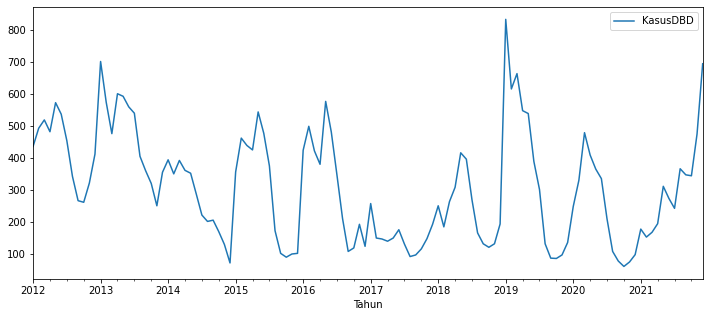

In [7]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

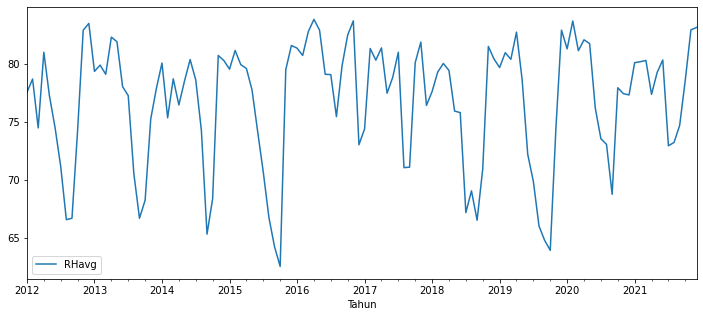

In [8]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['RHavg'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

TRAIN TEST SPLIT

In [9]:
data=dataTA[['KasusDBD', 'RHavg']]
data.shape

n = 12 # The last 12 months will be the test data. At least 1 year would be a good choice
train = data[0:-n]
test = data[-n:]

UJI STASIONER

In [10]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(train[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -2.270677
p-value                          0.181600
No Lags Used                     7.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                 -2.389542
p-value                         0.144710
No Lags Used                   12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




In [11]:
data_transformed=train.diff().diff()
data_transformed.dropna(inplace=True)
data_transformed

,KasusDBD,RHavg
Tahun,,
2012-03-01,-31.0,-5.35
2012-04-01,-63.0,10.73
2012-05-01,128.0,-10.29
2012-06-01,-127.0,1.04
2012-07-01,-47.0,-0.61
...,...,...
2020-08-01,24.0,2.16
2020-09-01,72.0,-3.81
2020-10-01,13.0,13.48


In [12]:
for name, column in data_transformed.iteritems():
    Augmented_Dickey_Fuller_Test_func(data_transformed[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                -6.668532e+00
p-value                        4.650910e-09
No Lags Used                   1.200000e+01
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                -6.488503e+00
p-value                        1.243495e-08
No Lags Used                   1.300000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




In [13]:
cointegration_test(data_transformed[['KasusDBD','RHavg']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KasusDBD >  88.42     > 12.3212   =>   True
RHavg  >  29.02     > 4.1296    =>   True


Text(0.5, 1.0, 'Partial Autocorrelation Function KasusDBD')

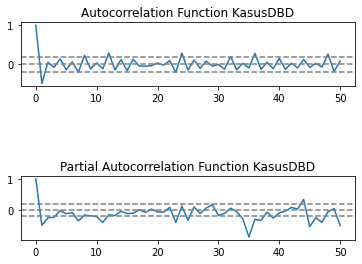

In [14]:
#KASUS DBD
kasusDBD_acf = acf(data_transformed['KasusDBD'], nlags=50)
kasusDBD_pacf = pacf(data_transformed['KasusDBD'], nlags=50, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(kasusDBD_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_transformed['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_transformed['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function KasusDBD')

#Plot PACF:
plt.subplot(313)
plt.plot(kasusDBD_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_transformed['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_transformed['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function KasusDBD')

Text(0.5, 1.0, 'Partial Autocorrelation Function RHAVG')

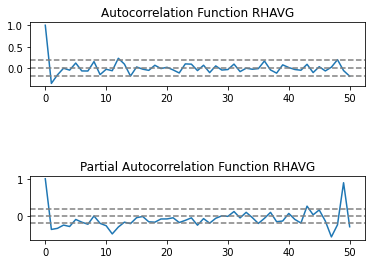

In [15]:
#RHAVG
rhavg_acf = acf(data_transformed['RHavg'], nlags=50)
rhavg_pacf = pacf(data_transformed['RHavg'], nlags=50, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(rhavg_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_transformed['RHavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_transformed['RHavg'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function RHAVG')

#Plot PACF:
plt.subplot(313)
plt.plot(rhavg_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_transformed['RHavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_transformed['RHavg'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function RHAVG')

AUTO ARIMA

In [16]:
pq = []
for name, column in data_transformed[['KasusDBD', 'RHavg']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data_transformed[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1372.101, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1345.064, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1340.398, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1336.394, Time=0.18 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1338.360, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1338.392, Time=0.14 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.956 seconds
optimal order for:KasusDBD is: (3, 0, 0) 


Searching order of p and q for : RHavg
Performing stepwise search to minimize aic
 ARIMA(1,0,

VARMA MODEL ORDER SELECTION

In [17]:
pq

[(3, 0, 0), (4, 0, 0)]

In [18]:
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(data_transformed, order=(i[0],i[2]))
        result=model.fit( disp=False)
        print(f'VARMA Order {i}')
        print('AIC {}'.format(result.aic))
        print('BIC {}'.format(result.bic))
        print()


c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (3, 0, 0)
AIC 1969.548112332386
BIC 2014.8265769322911

VARMA Order (4, 0, 0)
AIC 1954.0414019455002
BIC 2009.9736229218536



c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
varma_model = VARMAX(train[['KasusDBD','RHavg']], order=(4,0),enforce_stationarity= True)
fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                            
Dep. Variable:     ['KasusDBD', 'RHavg']   No. Observations:                  108
Model:                            VAR(4)   Log Likelihood                -918.686
                             + intercept   AIC                           1879.372
Date:                   Thu, 11 Aug 2022   BIC                           1935.697
Time:                           14:38:37   HQIC                          1902.210
Sample:                       01-01-2012                                         
                            - 12-01-2020                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.16, 0.03   Jarque-Bera (JB):         361.67, 0.05
Prob(Q):                        0.69, 0.87   Prob(JB):                   0.00, 0.98
Heteroskedasticity (H):         1.91, 1.09   Skew:                      1.84, -0.04
Prob(H) (t

In [20]:
korelasi=data_transformed.corr()

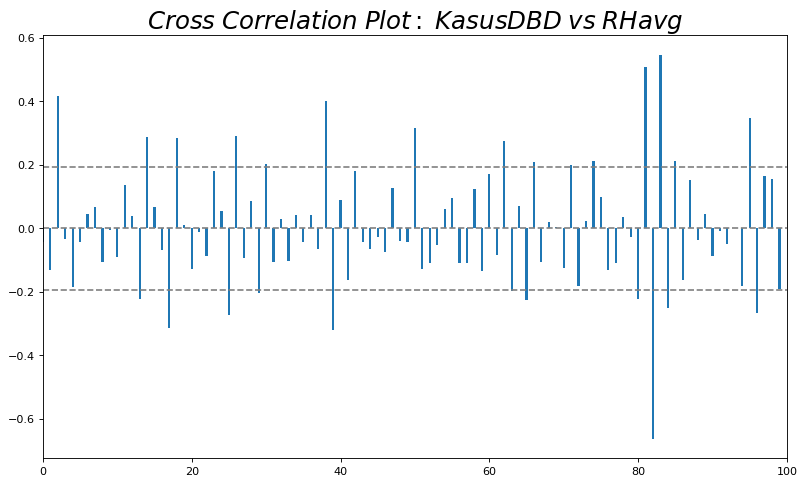

In [21]:
import statsmodels.tsa.stattools as stattools

#/* Import Data */

x = data_transformed['KasusDBD']
y = data_transformed['RHavg']

#/* Compute Cross Correlations */
ccs = stattools.ccf(x, y)[:100]
nlags = len(data_transformed)

#/* Compute the Significance level */
conf_level = 2 / np.sqrt(nlags)

#/* Draw Plot */
plt.figure(figsize=(12,7), dpi= 80)

plt.hlines(0, xmin=0, xmax=100,linestyle='--', color='gray')  # 0 axis
plt.hlines(conf_level, xmin=0, xmax=100,linestyle='--', color='gray')
plt.hlines(-conf_level, xmin=0, xmax=100,linestyle='--', color='gray')

plt.bar(x=np.arange(len(ccs)), height=ccs, width=.3)

#/* Decoration */
plt.title('$Cross\; Correlation\; Plot:\; KasusDBD\; vs\; RHavg$', fontsize=22)
plt.xlim(0,len(ccs))
plt.show()

In [22]:
data_transformed    

,KasusDBD,RHavg
Tahun,,
2012-03-01,-31.0,-5.35
2012-04-01,-63.0,10.73
2012-05-01,128.0,-10.29
2012-06-01,-127.0,1.04
2012-07-01,-47.0,-0.61
...,...,...
2020-08-01,24.0,2.16
2020-09-01,72.0,-3.81
2020-10-01,13.0,13.48


In [23]:
predict = fitted_model.get_prediction(start=0,end=len(data_transformed)-1)
prediction=predict.predicted_mean
prediction

,KasusDBD,RHavg
Tahun,,
2012-01-01,307.041856,76.698188
2012-02-01,406.844561,76.812865
2012-03-01,454.147342,78.089251
2012-04-01,484.513500,74.427186
2012-05-01,435.132087,79.411499
...,...,...
2020-06-01,337.505839,78.278537
2020-07-01,305.477902,73.272013
2020-08-01,156.669577,72.648685


In [24]:
inv_predict = inverse_diff(data,prediction)
inv_predict

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
Tahun,,,,
2012-01-01,307.041856,76.698188,387.958144,6.431812
2012-02-01,406.844561,76.812865,-18.886416,-70.381053
2012-03-01,454.147342,78.089251,-473.033758,-148.470303
2012-04-01,484.513500,74.427186,-957.547258,-222.897489
2012-05-01,435.132087,79.411499,-1392.679345,-302.308988
...,...,...,...,...
2020-06-01,337.505839,78.278537,-31853.956694,-7736.064500
2020-07-01,305.477902,73.272013,-32159.434596,-7809.336513
2020-08-01,156.669577,72.648685,-32316.104174,-7881.985198


In [37]:
test = data[2:-n]
for i in ['KasusDBD','RHavg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , prediction[str(i)])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 29157.49805196446
MAE is : 130.9380501617077
RMSE is : 170.75566770085396
MAPE is : 0.5952468338408442

Evaluation metric for RHavg
Evaluation metric results:-
MSE is : 38.089723160646365
MAE is : 5.0336053378896395
RMSE is : 6.171687221550227
MAPE is : 0.06713432176826244



In [39]:
test_vs_prediction = pd.concat([data,prediction],axis=1)
test_vs_prediction.dropna(inplace=True)
test_vs_prediction

,KasusDBD,RHavg,KasusDBD,RHavg
Tahun,,,,
2012-01-01,436.0,77.55,307.041856,76.698188
2012-02-01,493.0,78.69,406.844561,76.812865
2012-03-01,519.0,74.48,454.147342,78.089251
2012-04-01,482.0,81.00,484.513500,74.427186
2012-05-01,573.0,77.23,435.132087,79.411499
...,...,...,...,...
2020-06-01,335.0,76.20,337.505839,78.278537
2020-07-01,209.0,73.55,305.477902,73.272013
2020-08-01,107.0,73.06,156.669577,72.648685


<AxesSubplot:xlabel='Tahun'>

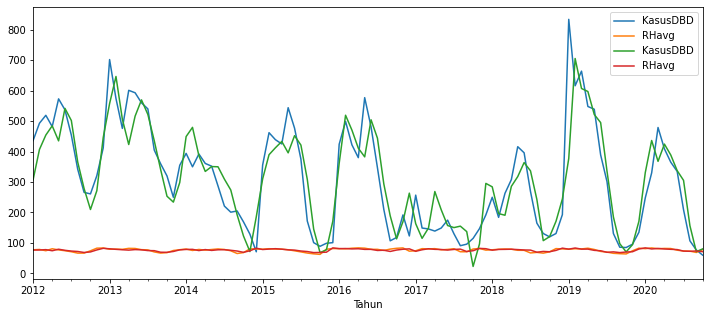

In [40]:
test_vs_prediction.plot(figsize=(12,5))

In [41]:
forecast = fitted_model.get_prediction(start=0,end=len(data_transformed)+(n*2)-1)
forecast=forecast.predicted_mean
forecast

,KasusDBD,RHavg
2012-01-01,307.041856,76.698188
2012-02-01,406.844561,76.812865
2012-03-01,454.147342,78.089251
2012-04-01,484.513500,74.427186
2012-05-01,435.132087,79.411499
...,...,...
2022-06-01,290.850434,77.004507
2022-07-01,288.123988,76.837198
2022-08-01,285.744940,76.743908
2022-09-01,284.807742,76.725498


In [42]:
inv_forecast = inverse_diff(data,forecast)
inv_forecast

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
2012-01-01,307.041856,76.698188,387.958144,6.431812
2012-02-01,406.844561,76.812865,-18.886416,-70.381053
2012-03-01,454.147342,78.089251,-473.033758,-148.470303
2012-04-01,484.513500,74.427186,-957.547258,-222.897489
2012-05-01,435.132087,79.411499,-1392.679345,-302.308988
...,...,...,...,...
2022-06-01,290.850434,77.004507,-37392.758680,-9584.519478
2022-07-01,288.123988,76.837198,-37680.882668,-9661.356676
2022-08-01,285.744940,76.743908,-37966.627608,-9738.100583
2022-09-01,284.807742,76.725498,-38251.435350,-9814.826082


In [43]:
test_vs_forescast = pd.concat([data,forecast],axis=1)
test_vs_forescast.tail(24)

,KasusDBD,RHavg,KasusDBD,RHavg
2020-11-01,74.0,77.43,84.400201,79.988586
2020-12-01,97.0,77.32,198.106789,78.471376
2021-01-01,177.0,80.10,204.283973,78.010892
2021-02-01,152.0,80.18,200.384016,79.619976
2021-03-01,167.0,80.29,236.003030,79.862676
2021-04-01,194.0,77.37,267.427107,79.625658
2021-05-01,311.0,79.26,279.909509,78.554010
2021-06-01,273.0,80.33,273.195893,77.830984
2021-07-01,242.0,72.94,257.435522,77.243685
2021-08-01,366.0,73.23,244.203329,76.783293


<AxesSubplot:>

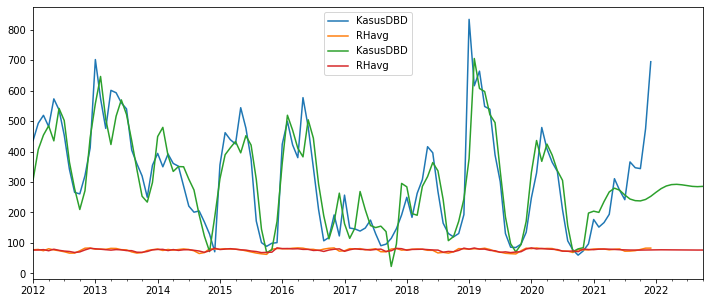

In [44]:
test_vs_forescast.plot(figsize=(12,5))

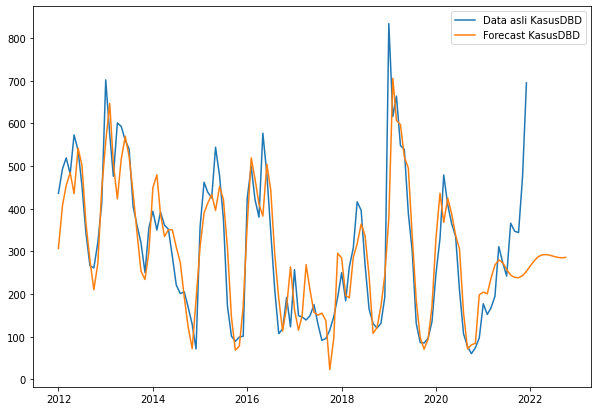

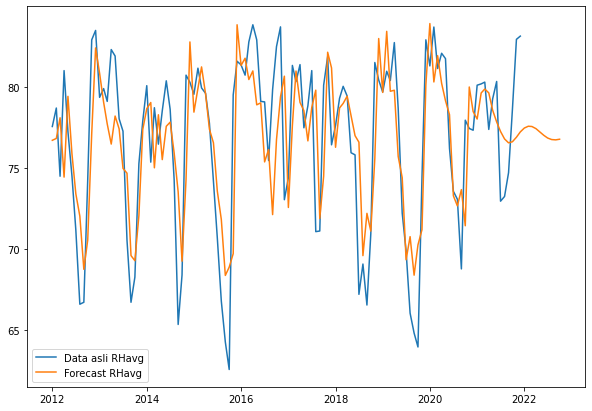

In [45]:
for i in ['KasusDBD','RHavg']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(data[str(i)], label='Data asli '+str(i))
    plt.plot(forecast[str(i)], label='Forecast '+str(i))
    plt.legend(loc='best')
    plt.show()